# Time Series Analysis: Fitbit Data

-Steven Garis, Matthew Capper

## Plan: 
### We have been given fitbit data spread across several csv files from a mystery source.  Our goal, through exploration of our data, is to determine the type of subject the fitbit data was gleaned from and to predict the missing time data at the end of our subject's logs.

In [48]:
# environment set-up:

# import zgulde.extend_pandas
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
from scipy import stats
from sklearn import metrics
import math

import itertools

# data visualization 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams


%matplotlib inline

# modeling:
from statsmodels.tsa.api import Holt
from fbprophet import Prophet
import model_fitbit
from fbprophet.diagnostics import cross_validation, performance_metrics
from sklearn import svm



# ignore warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import acquire_fitbit
import prepare_fitbit
import summarize

## Acquisition:
### We will read in from several csv files and compund the data into a pandas dataframe that we will work with in the confines of the notebook.  Functions are detailed in the acquire_fitbit.py script utilized.

In [49]:
# acquire fitbit data from csv files into a working dataframe
df = acquire_fitbit.get_fitbit()

## Preparation:
### Data will be cleaned in a matter that we may analyze the subject by time.  Data values cleaned of punctuation and converted to numeric types, date interpreted as a datetime format and turned into the index of our dataframe.  Functions detailed in prepare_fitbit.py script

In [50]:
# clean and prepare our dataframe for analysis
df = prepare_fitbit.prep_data(df)

In [51]:
# check for null values after cleaning: 
summarize.get_nulls_by_column(df)

,sum_nulls,nulls_by_percent


In [52]:
# check for null values after cleaning: 
summarize.nulls_by_row(df)

,num_cols_missing,pct_cols_missing,date
0,0,0.0,225


We have no null values in our dataframe after cleaning, which is great.  This means that the only values we are missing are the values from the dates that were not included at the end of our dataset from the dates 2018-12-07 to 2018-12-28

Note, we are only observing the activity logs from our initial raw csv data.  Cursory glance at the CSV files made it apparent that there was a miniscule amount of data filled in for caloric/dietary input.  Whatever subject had this fitbit was not dilligent in filling out this data and did so for such a short period of time that there is no utility in trying to keep roughly one week in a total frame of 225 days. As a result, this part of the csv was disregarded in the process of the file read rather than dropped once implemented into a pandas dataframe.

In [53]:
print('Total days: ', df.index.nunique())
print('Start date: ',df.index.min())
print('End date  : ',df.index.max())

Total days:  225
Start date:  2018-04-26 00:00:00
End date  :  2018-12-06 00:00:00


In [54]:
# let's look at our datatypes:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
floors                      int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
year                        int64
quarter                     int64
month                       int64
day_of_month                int64
day_of_week                object
is_weekend                   bool
dtype: object

## Exploration:
### We will investigate the data we have gathered to assess what type of subject that we have data on.

Potential subject types: 

-Patients in drug trials 

-Patients testing fitness equipment 
 
-patients in "experimentation" 

-staff members


In [55]:
df.index.max() - timedelta(weeks=4)

Timestamp('2018-11-08 00:00:00', freq='D')

In [56]:
# train/test split:
train = df[:'2018-11-08']
test = df['2018-11-08':]

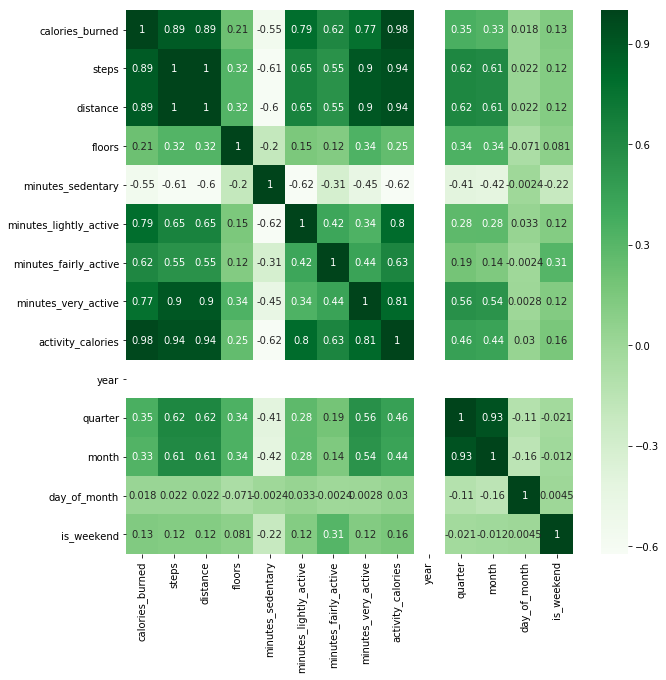

In [57]:
plt.figure(figsize=(10,10))
sns.heatmap(data=train.corr(), annot=True, cmap='Greens')

In [58]:
df.groupby('day_of_week')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
day_of_week,,,,
Fri,3464.718750,8847.250000,4.180625,11.062500
Mon,3242.750000,7245.406250,3.439688,6.718750
Sat,3553.187500,9549.656250,4.591563,13.562500
Sun,3551.468750,9904.500000,4.669062,21.843750
Thu,3425.939394,8748.636364,4.157576,12.545455
Tue,3304.093750,7856.875000,3.702813,11.250000
Wed,3270.468750,7594.343750,3.582812,11.156250


In [59]:
df.groupby('is_weekend')[['calories_burned','steps','distance','floors']].mean()

,calories_burned,steps,distance,floors
is_weekend,,,,
False,3342.118012,8062.788820,3.814845,10.559006
True,3552.328125,9727.078125,4.630312,17.703125


Note that mean calories burned increases significantly on the weekends, floors increases dramatically and distance and steps increase marginally.

What can we interpolate from this?

We know that we have a subject that is more active on the weekends.  This likely means that whatever subject we have is on a regular work-week schedule and increases activity on the weekend.  We would suppose at this point that this subject is most likely an employee at the facility or someone on a drug trial, as a experimental subject would likely be continuously involved in a trial rather than stuck on a work-week rotation.  Drug trial is somewhat unlikely due to the inconsistency of the voluntary inputted data in the fitbit csv files.  If a subject was given a fitbit to input data for metric tracking, we would likely either see consistently input data or consistent data at the beginning that trailed off as the trial pushed forward.  This is not the case with the data we were given.

In [60]:
columns = prepare_fitbit.get_feature_list(train)

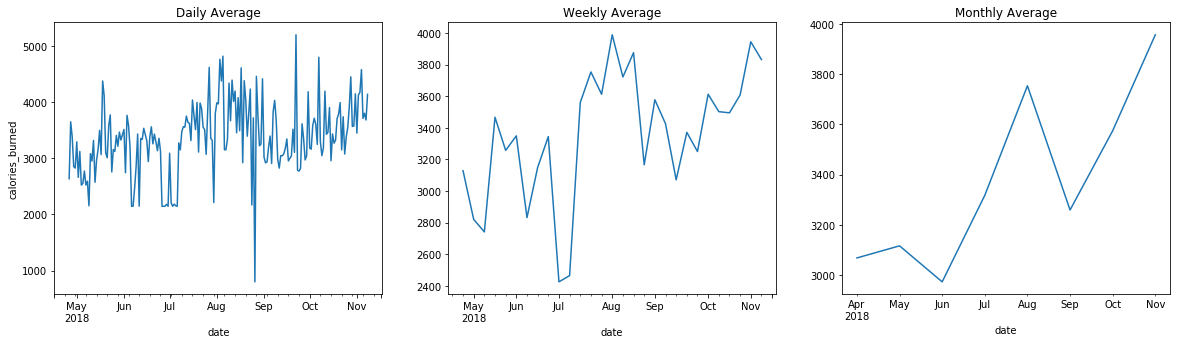

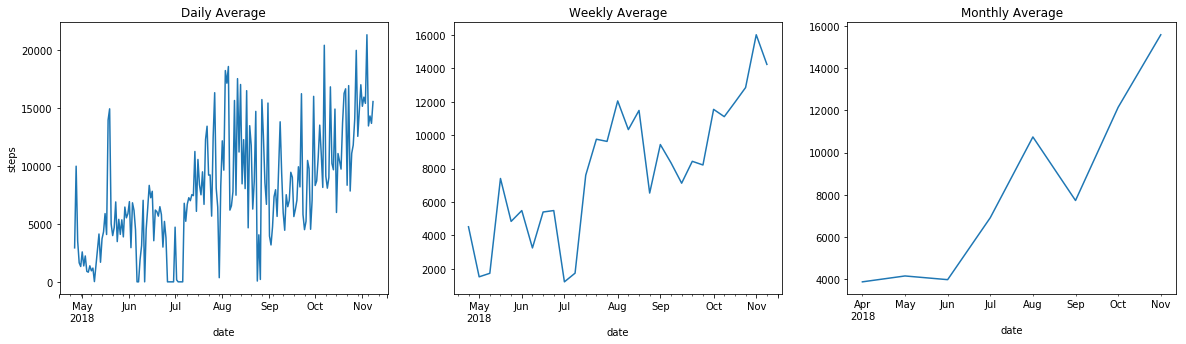

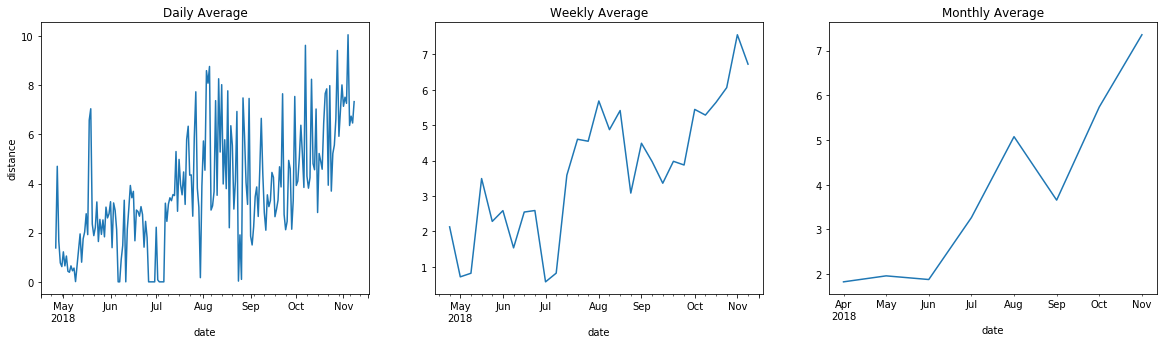

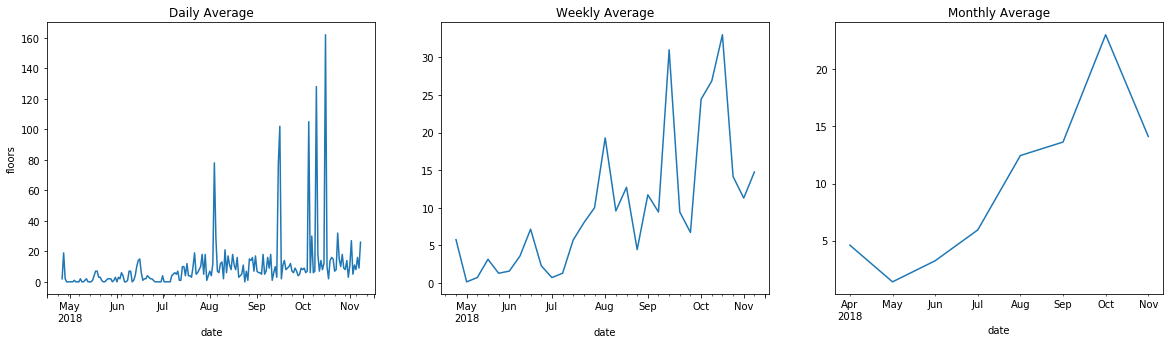

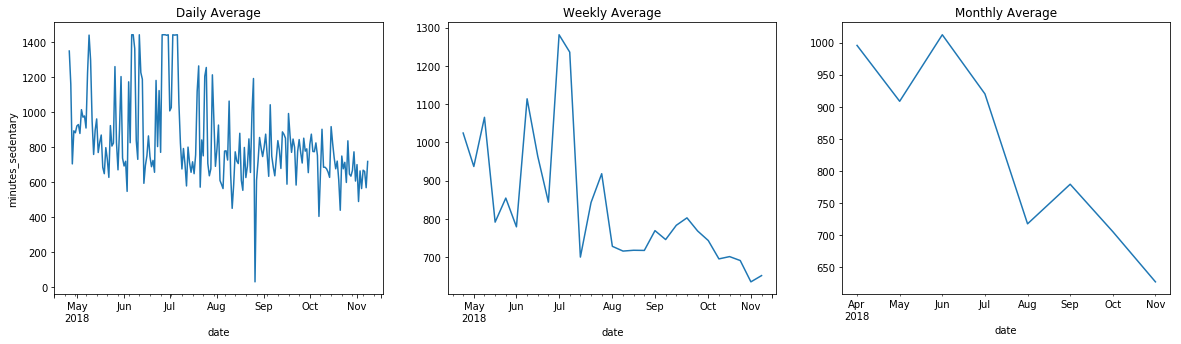

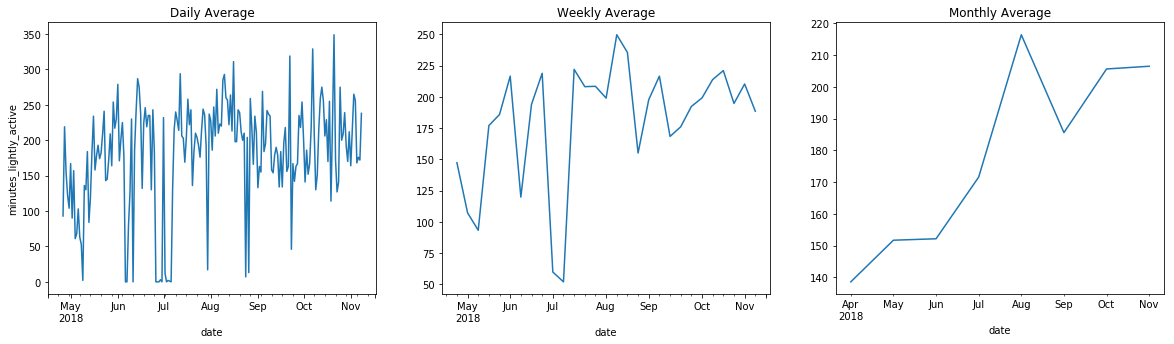

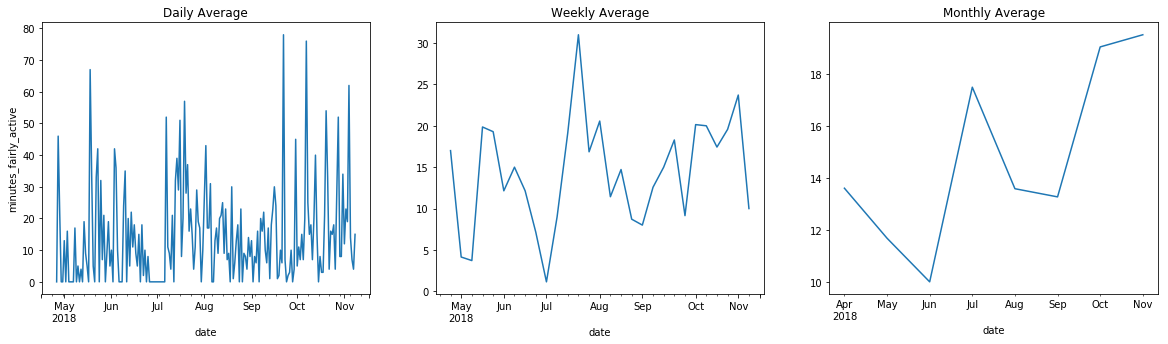

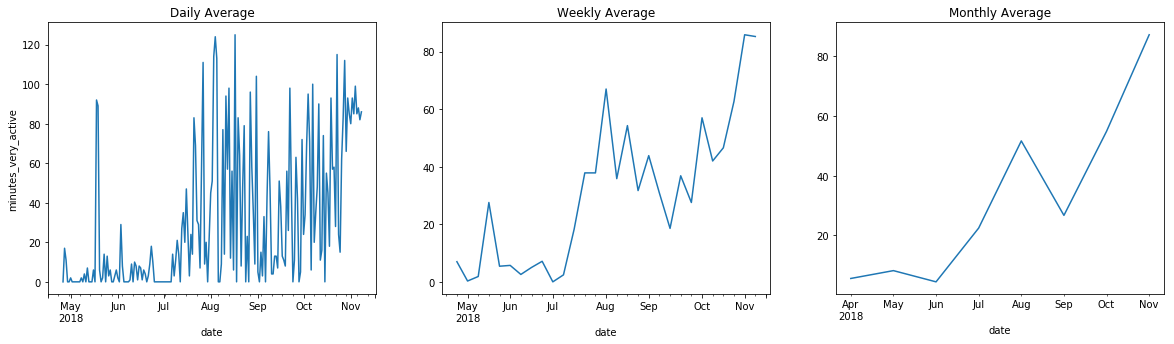

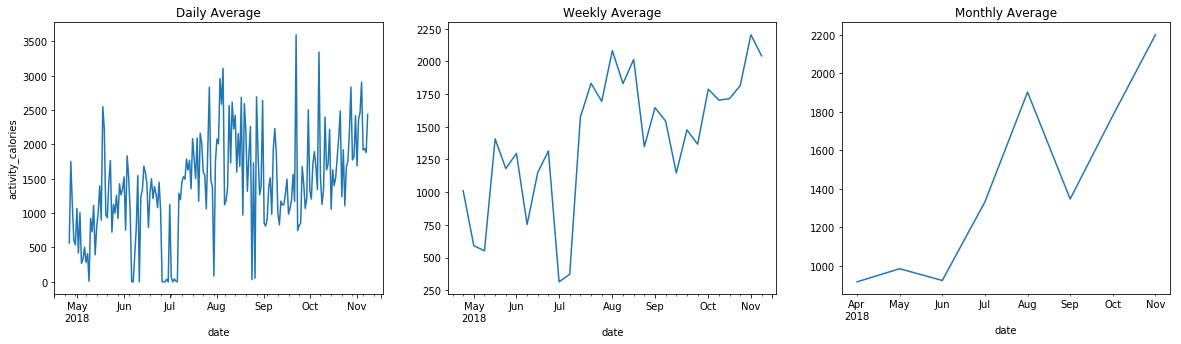

In [61]:
# plotting based on means:
for feature in columns[0:9]:
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Daily Average')
    plt.ylabel(feature)
    train.resample('D')[feature].mean().plot()

    plt.subplot(132)
    plt.title('Weekly Average')
    train.resample('W')[feature].mean().plot()

    plt.subplot(133)
    plt.title('Monthly Average')
    train.resample('M')[feature].mean().plot()

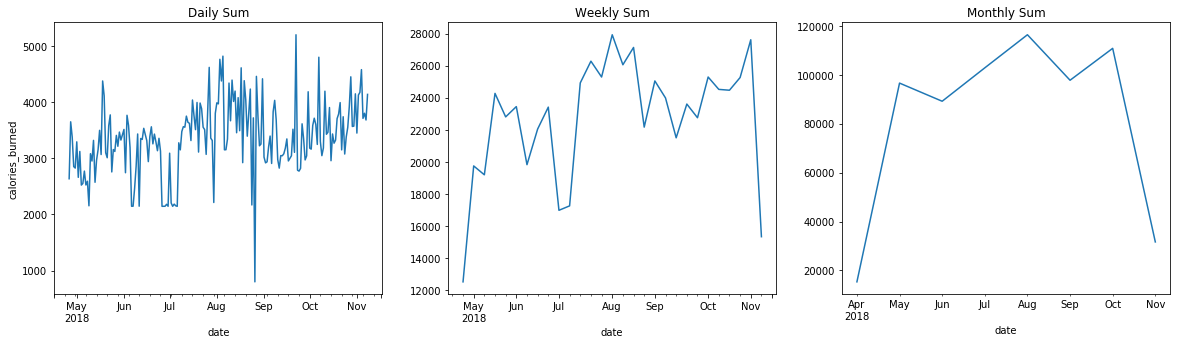

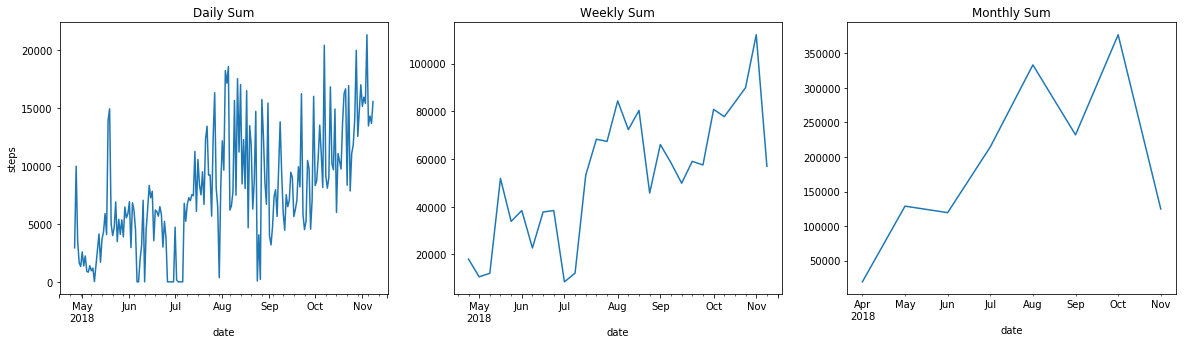

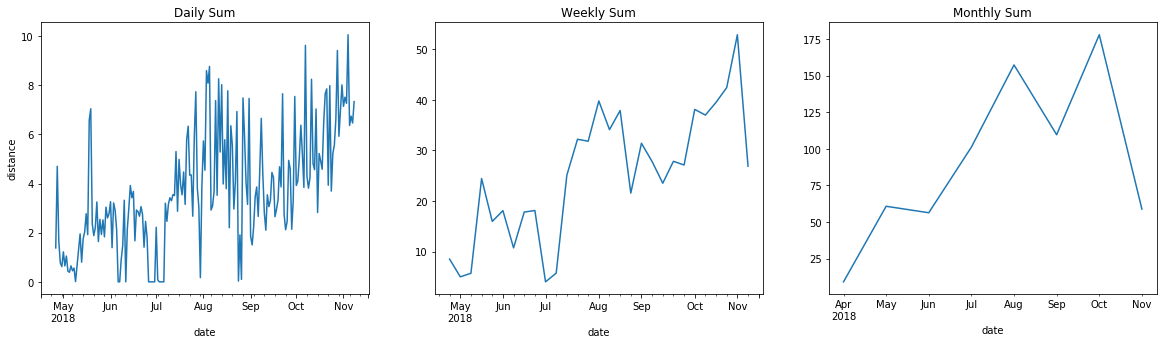

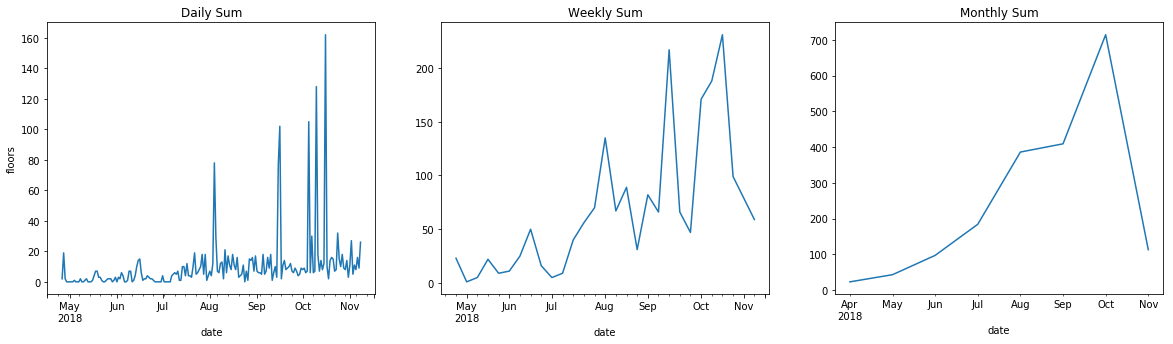

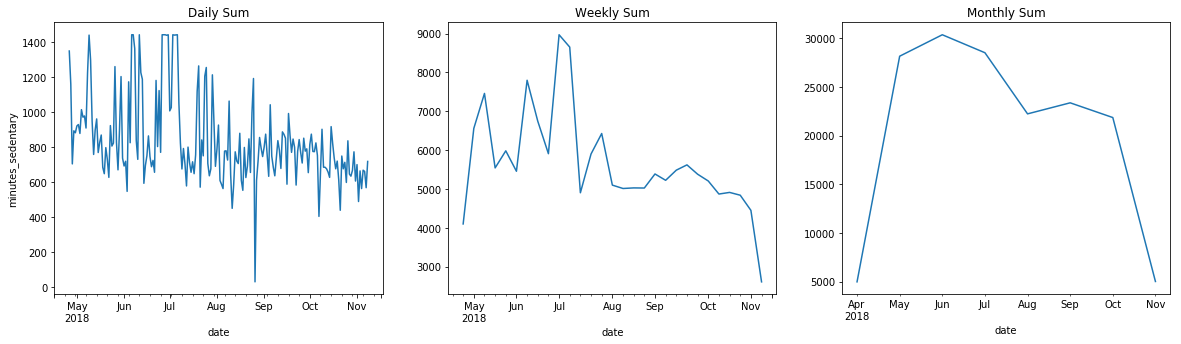

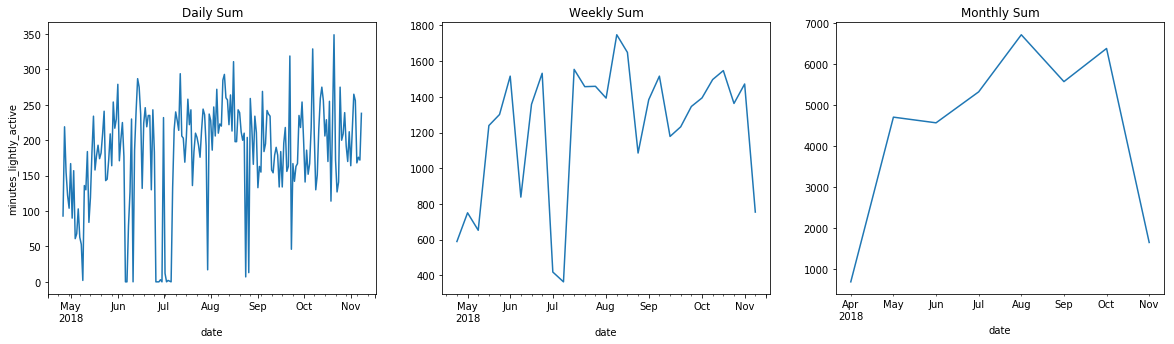

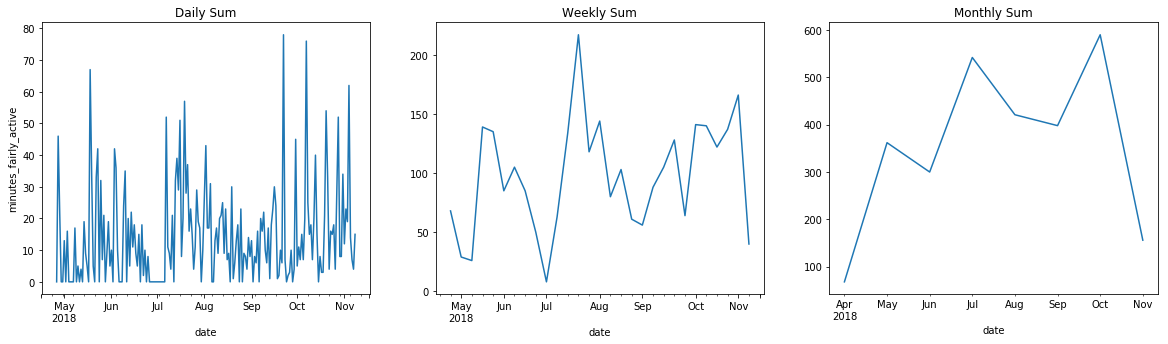

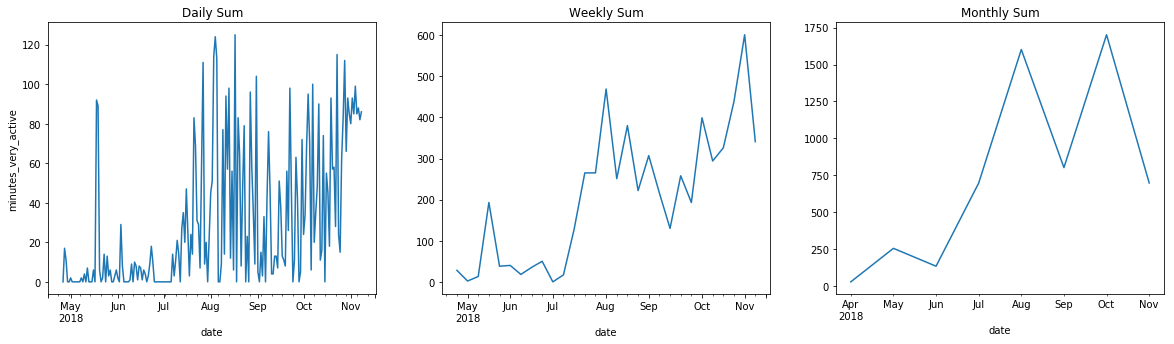

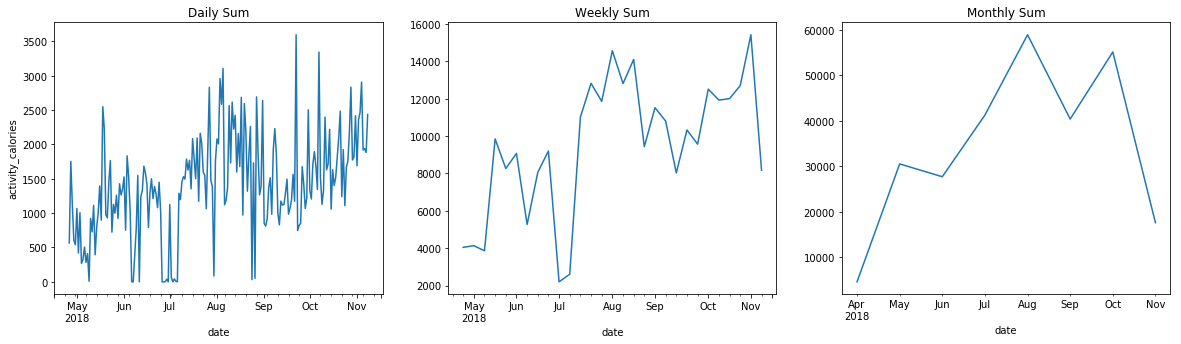

In [62]:
# plotting based on sums: 
for feature in columns[0:9]:
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Daily Sum')
    plt.ylabel(feature)
    train.resample('D')[feature].sum().plot()

    plt.subplot(132)
    plt.title('Weekly Sum')
    train.resample('W')[feature].sum().plot()

    plt.subplot(133)
    plt.title('Monthly Sum')
    train.resample('M')[feature].sum().plot()

In [63]:
columns

['calories_burned',
 'steps',
 'distance',
 'floors',
 'minutes_sedentary',
 'minutes_lightly_active',
 'minutes_fairly_active',
 'minutes_very_active',
 'activity_calories',
 'year',
 'quarter',
 'month',
 'day_of_month',
 'day_of_week',
 'is_weekend']

### It appears that there are several days where the subject did not have any activity logged. It also appears that the activity starts increasing rapidly after the beginning of July.  Let's investigate how many days in the dataframe are like this.

In [64]:
df.loc[df.steps == 0]

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,year,quarter,month,day_of_month,day_of_week,is_weekend
date,,,,,,,,,,,,,,,
2018-06-06,2145,0,0.0,0,1440,0,0,0,0,2018,2,6,6,Wed,False
2018-06-07,2146,0,0.0,0,1440,0,0,0,0,2018,2,6,7,Thu,False
2018-06-11,2146,0,0.0,0,1440,0,0,0,0,2018,2,6,11,Mon,False
2018-06-26,2144,0,0.0,0,1440,0,0,0,0,2018,2,6,26,Tue,False
2018-06-27,2145,0,0.0,0,1440,0,0,0,0,2018,2,6,27,Wed,False
2018-06-28,2145,0,0.0,0,1440,0,0,0,0,2018,2,6,28,Thu,False
2018-06-29,2180,0,0.0,0,1437,3,0,0,39,2018,2,6,29,Fri,False
2018-06-30,2145,0,0.0,0,1440,0,0,0,0,2018,2,6,30,Sat,True
2018-07-03,2144,0,0.0,0,1440,0,0,0,0,2018,3,7,3,Tue,False


### There is data missing sporadically through june and then in the four-day span in the fourth of July holiday.

Based on this data, we can postulate that this person likely was not wearing their fitbit on these days.  Whatever happened during the fourth of July weekend clearly prompted the subject to begin training, as this span of dead air leads immediately into the training ramp that goes up through the remainder of the data set.

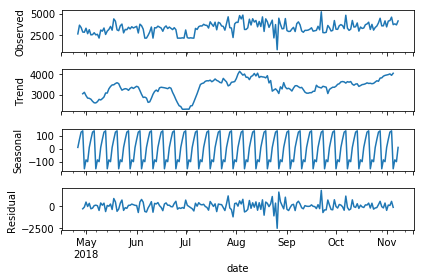

In [65]:
cal_burn = train.resample('D').calories_burned.mean()

decomposition = sm.tsa.seasonal_decompose(cal_burn, model='additive')
fig = decomposition.plot()


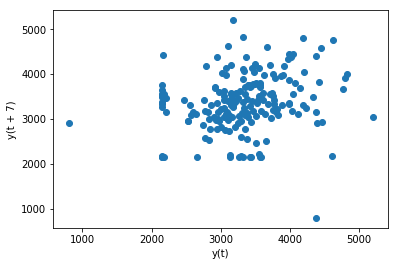

In [66]:
# patterns appear to be largely weekly as we observed, let's 
# investigate a lag plot of caloric burn based on weekly cycles:
pd.plotting.lag_plot(cal_burn, lag=7)

Scattered results from our lag plot, though still a net positive correlation in the spread of our data.

## Modeling:
### We will investigate several different modeling techniques in order to impute our missing values from the later portion of December.

In [67]:
aggregation = 'mean'
train = df[:'2018-11-08'].calories_burned.resample('D').agg(aggregation)

test = df['2018-11-08':].calories_burned.resample('D').agg(aggregation)

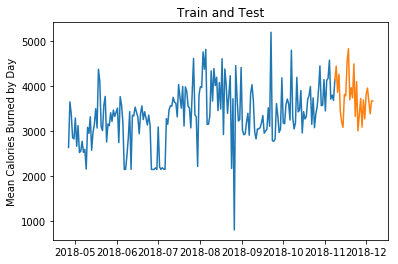

In [68]:
plt.plot(train)
plt.plot(test)
plt.title('Train and Test')
plt.ylabel('Mean Calories Burned by Day')
plt.show()

### We will start with a simple mean estimate and build complexity from there.

In [69]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()

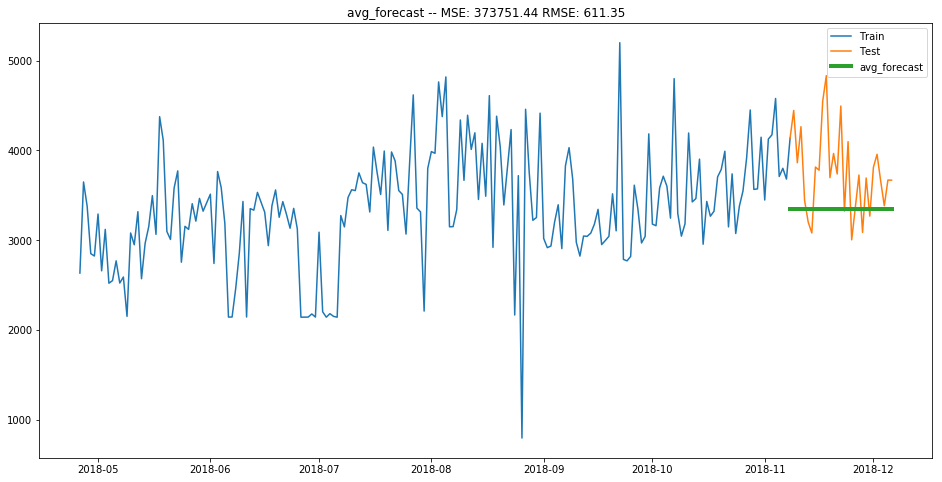

In [70]:
model_fitbit.plot_and_eval(yhat.avg_forecast, train=train, test=test, actual=test)

### We start out here with a mean squared error of 373751 and a root mean squared error of 611.

### Next we will model based on a rolling mean:

In [71]:
periods = 7
yhat['moving_avg_forecast_7'] = train.rolling(7).mean().iloc[-1]


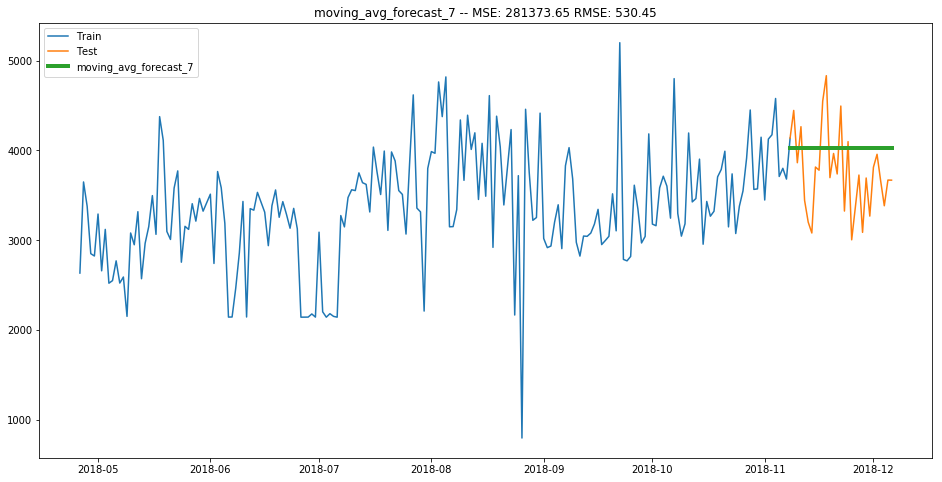

In [72]:
model_fitbit.plot_and_eval(yhat.moving_avg_forecast_7, train=train, test=test, actual=test)

### This model is an improvement, with a RMSE of 530.  Let's roll through some more period iterations to improve the error.

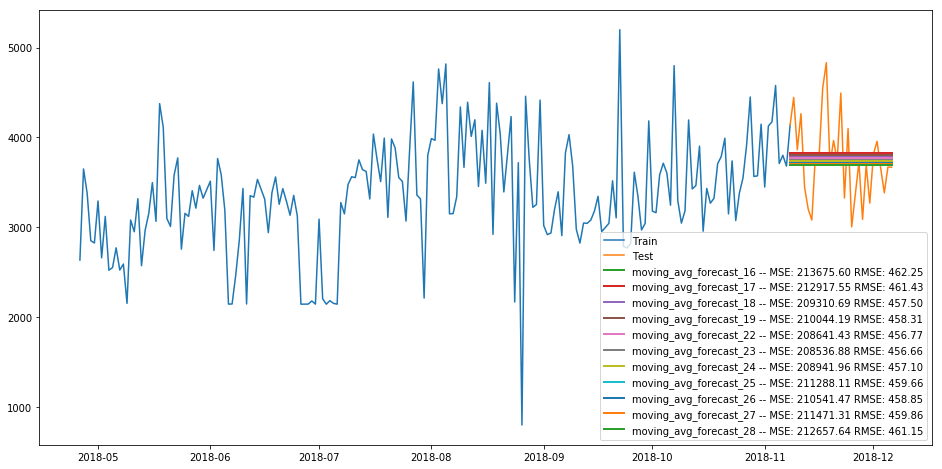

In [73]:
period_vals = [16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

model_fitbit.plot_and_eval(forecasts, linewidth=2, train=train, test=test, actual=test)

### We were able to improve our model significantly.  The best we see here is a RMSE of 456.66 with 23 periods.

### Holt model: 

In [74]:
holt = Holt(train).fit(smoothing_level=.6, smoothing_slope=.2)
yhat = pd.DataFrame(dict(actual=test))
yhat['holt_linear'] = holt.forecast(test.shape[0])

In [75]:
yhat.head()

,actual,holt_linear
date,,
2018-11-08,4137,NaN
2018-11-09,4445,3982.665105
2018-11-10,3863,3993.274173
2018-11-11,4264,4003.883241
2018-11-12,3444,4014.492309


In [76]:
# fill the first NaN value with an approxomation
yhat = yhat.fillna(3970.0)

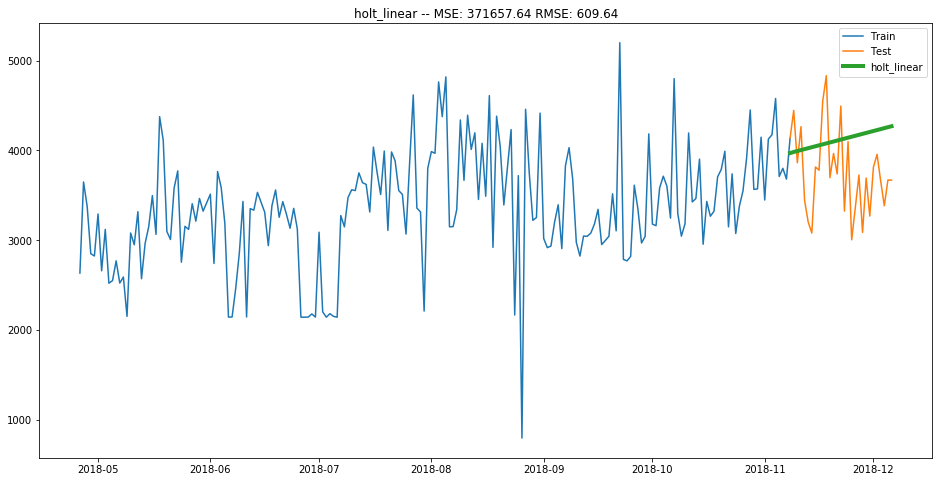

In [77]:
model_fitbit.plot_and_eval(yhat.holt_linear,train=train, test=test, actual=test)

#### Our best model from parametric analysis by rmse looks to be the rolling average with a period of 23.  We can forecast data we are missing based on these flat rates: 

In [78]:
#create a dataframe of our missing values based on the best parametric model
missing_vals = model_fitbit.impute_missing_rolling(df, columns[:9])

### Let's check out another model type: SVM

In [81]:

def embed_data(x, steps):
    n = len(x)
    xout = np.zeros((n-steps, steps))
    yout = x[steps:]
    for i in np.arange(steps, n):
        xout[i-steps] = x[i-steps:i]
    return xout, yout

df = df[['calories_burned','steps','distance','floors','minutes_sedentary','minutes_lightly_active','minutes_fairly_active','minutes_very_active','activity_calories']]

aggregation = 'mean'

for col in df:
    train = df[:'2018-11-08'][col].resample('D').agg(aggregation)
    test = df['2018-11-08':][col].resample('D').agg(aggregation)

    xtrain,ytrain = embed_data(train, 3)
    xtest,ytest = embed_data(test, 3)

    m = svm.SVR(kernel='rbf', C=1, gamma=0.1)
    m_fit = m.fit(xtrain, ytrain)

    y_pred = m_fit.predict(xtrain)
    mse = metrics.mean_squared_error(y_pred, ytrain)
    rmse = math.sqrt(mse)
    print(col, 'Train RMSR: ', rmse)

    y_pred = m_fit.predict(xtest)
    mse = metrics.mean_squared_error(y_pred, ytest)
    rmse = math.sqrt(mse)
    print(col, 'Test RMSR: ', rmse)

    print('--'*10)

calories_burned Train RMSR:  638.6622343522415
calories_burned Test RMSR:  585.2146877593135
--------------------
steps Train RMSR:  5138.44267620044
steps Test RMSR:  7319.182337949633
--------------------
distance Train RMSR:  1.6501220131271959
distance Test RMSR:  2.2249518764985163
--------------------
floors Train RMSR:  19.061840317554054
floors Test RMSR:  55.63129912529616
--------------------
minutes_sedentary Train RMSR:  250.2543889217582
minutes_sedentary Test RMSR:  177.062346690042
--------------------
minutes_lightly_active Train RMSR:  76.2827475568797
minutes_lightly_active Test RMSR:  65.84317453680526
--------------------
minutes_fairly_active Train RMSR:  15.196846250030617
minutes_fairly_active Test RMSR:  17.26971627697463
--------------------
minutes_very_active Train RMSR:  38.268371194456336
minutes_very_active Test RMSR:  56.62233921591817
--------------------
activity_calories Train RMSR:  738.8895811319561
activity_calories Test RMSR:  835.4489925966571
---

#### Root mean squared error on our calories burned still isnt great compared to our first couple models.  Let's push ahead and compare with a Prophet based model: 

### Modeling phase three: Prophet

We could ideally get a better projection if we use something a bit more nuanced and variable, so we will attempt to model utilizing Facebook's Prophet.

In [82]:
# create our d_df to use with prophet: 
d_df = df
# reset the index to work with dates in prophet:
d_df.reset_index(inplace=True)

d_df['y'] = df.calories_burned
d_df['ds'] = pd.to_datetime(d_df.date)
d_df = d_df[['ds', 'y']]

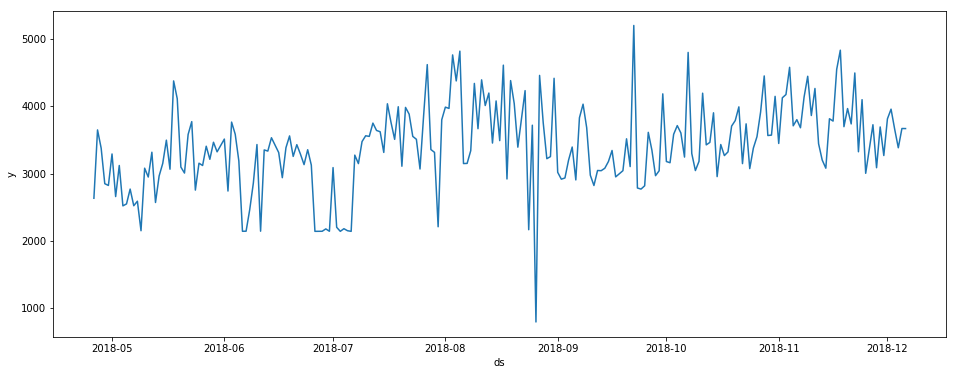

In [83]:
# plot values before modeling:
plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [84]:
# set caps manually based on reasonable caloric output
d_df['cap'] = 5000
d_df['floor'] = 2000

m = Prophet(growth='logistic', daily_seasonality=True)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [85]:
# check future dataframes
future = m.make_future_dataframe(periods=180)
future['floor'] = 2000
future['cap'] = 5000
print(future.head())
print(future.tail())
print(d_df.tail())

          ds  floor   cap
0 2018-04-26   2000  5000
1 2018-04-27   2000  5000
2 2018-04-28   2000  5000
3 2018-04-29   2000  5000
4 2018-04-30   2000  5000
            ds  floor   cap
400 2019-05-31   2000  5000
401 2019-06-01   2000  5000
402 2019-06-02   2000  5000
403 2019-06-03   2000  5000
404 2019-06-04   2000  5000
            ds     y   cap  floor
220 2018-12-02  3957  5000   2000
221 2018-12-03  3660  5000   2000
222 2018-12-04  3384  5000   2000
223 2018-12-05  3670  5000   2000
224 2018-12-06  3669  5000   2000


In [86]:
# create forecast dataframe, check tail values
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
400,2019-05-31,4770.023697,4007.525062,5537.114651
401,2019-06-01,4855.138108,4091.646417,5519.072123
402,2019-06-02,4852.629745,4101.457061,5688.580612
403,2019-06-03,4551.886938,3777.326875,5259.508833
404,2019-06-04,4610.605065,3831.917862,5294.695720


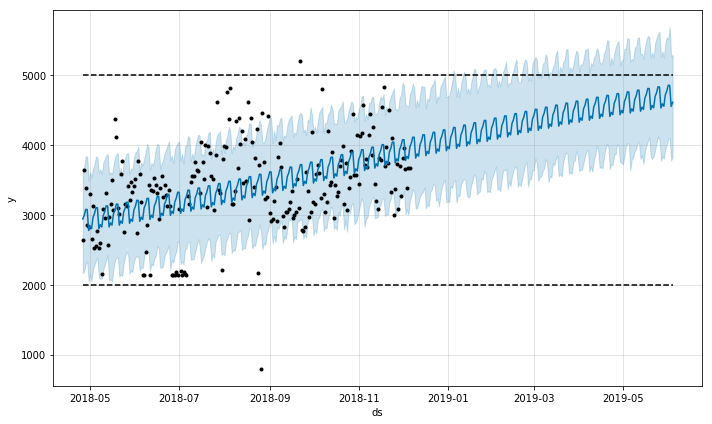

In [87]:
# plot predictions
fig1 = m.plot(forecast)

In [88]:
# check metrics: 
df_cv = cross_validation(m, horizon='30 days', period='14 days')


df_p = performance_metrics(df_cv)

avg_rmse = float(df_p['rmse'].mean())
print('Average root mean squared error for calories burned on this model: {:2f}'.format(avg_rmse))

INFO:fbprophet:Making 8 forecasts with cutoffs between 2018-07-31 00:00:00 and 2018-11-06 00:00:00


Average root mean squared error for calories burned on this model: 634.452276


The mean squared error is somewhat surprisingly not great on this prophet model.  634 is significantly higher than our flat rate parametric models.

## We will build a model intuitively using what we know about the data.  There is a schism in the subject's activity around the 4th of July holiday.  Knowing this, we should be able to make a more consistent model based on the subject's activity following what they have done after this date.

In [89]:
#cut d_df to be after the 4th of July holiday: 
d_df = d_df[72:]

We also choose to create our model based on the feature calories burned.  The fitbit includes a basic metabolic rate that imputes reasonable values for days when the subject was not wearing the device.  We can choose to build the rest of the model based on these values.

In [90]:
# manually set caps and floor for calories burned to test
d_df['cap'] = 5000
d_df['floor'] = 2000

m = Prophet(growth='logistic', changepoint_range=.7)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


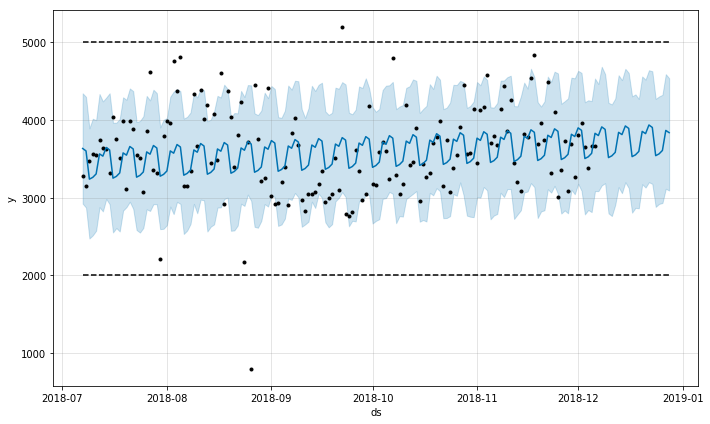

In [91]:
# make new future dataframe with new model functionality: 
future = m.make_future_dataframe(periods=22)
future['cap'] = 5000
future['floor'] = 2000

forecast = m.predict(future)

fig1 = m.plot(forecast)


In [92]:
df_cv = cross_validation(m, horizon='30 days', period='14 days')


df_p = performance_metrics(df_cv)

avg_rmse = float(df_p['rmse'].mean())
print('Average root mean squared error for calories burned on this model: {:2f}'.format(avg_rmse))

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-10-09 00:00:00 and 2018-11-06 00:00:00


Average root mean squared error for calories burned on this model: 426.920005


### We can see here that the root mean squared error has improved significantly over any of our other models.  We will finalize predictions for our subject based around this model.

In [93]:
missing_vals_p = model_fitbit.impute_missing_prophet(d_df, df, columns[2:9])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [94]:
#values based on flat-rate parametric rolling mean:
missing_vals

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,2018-12-07,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
1,2018-12-08,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
2,2018-12-09,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
3,2018-12-10,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
4,2018-12-11,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
5,2018-12-12,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
6,2018-12-13,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
7,2018-12-14,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
8,2018-12-15,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304
9,2018-12-16,3750.956522,14161.521739,6.680435,12.782609,655.173913,204.391304,19.869565,71.826087,1984.391304


In [95]:
#values based with prophet: 
missing_vals_p

,date,calories_burned,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
153,2018-12-07,3799.025570,7.000700,19.651918,634.410839,230.689903,0.541360,87.530531,2130.902438
154,2018-12-08,3911.499088,7.666505,23.108341,562.398892,249.854376,10.408646,91.053016,2299.343262
155,2018-12-09,3879.652051,7.818071,35.821714,525.997521,255.417737,11.461463,96.890938,2368.231291
156,2018-12-10,3515.988489,6.305556,14.393245,626.359169,223.042309,-1.951539,70.342996,1847.040123
157,2018-12-11,3538.708919,6.593478,21.143217,644.673030,226.234072,-7.679604,75.925198,1853.345288
158,2018-12-12,3582.959988,6.473510,21.110343,649.883613,229.471360,-3.494071,71.482464,1906.969764
159,2018-12-13,3841.069345,7.418318,23.034966,647.549689,252.179324,-1.948527,86.928104,2208.025827
160,2018-12-14,3810.625553,7.149661,20.145131,626.465199,232.976136,0.352393,90.804180,2158.395194
161,2018-12-15,3923.095124,7.814820,23.602826,554.494500,252.135483,10.224471,94.308175,2326.797359
162,2018-12-16,3891.244113,7.965735,36.317471,518.134304,257.693708,11.281961,100.127305,2395.646445


In [101]:
#prophet imputed some negative values for minutes fairly active, so let's correct that:
missing_vals_p['minutes_fairly_active'][missing_vals_p.minutes_fairly_active < 0]
missing_vals_p['minutes_fairly_active'] = missing_vals_p.minutes_fairly_active.apply(lambda x: x if x >= 0 else x*-1)

In [105]:
#create a csv: 
missing_vals_p.to_csv('missing_data.csv')